### Ensemble 

- 단일 모델 앙상블

In [3]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import pandas as pd
from Utils import inference_view
from Datasets import *
from Models import *
from SwinTransformer import *
import torch

from tqdm import tqdm

In [4]:
weights = [
    '/opt/ml/code/saved/mIoU_swin_small_512_stepRL.pt',
    '/opt/ml/code/saved/mIoU_swin_small_512_stepRL_CLAHE.pt'
]


def get_pretrained_model(path):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = SwinTransformerSmall()
    model_path = path

    # best model 불러오기
    print(device)
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint)
    return model

raw_model = get_pretrained_model(weights[0])
transformed_model = get_pretrained_model(weights[1])


def collate_fn(batch):
    return tuple(zip(*batch))

test_transform = A.Compose([
    # A.CLAHE(p=1),
    ToTensorV2()
])
raw_data = RecylceDatasets(data_dir='../input/data/test.json', mode='test', transform=test_transform,
                              # resize=512
                              )

test_transform = A.Compose([
    A.CLAHE(p=1),
    ToTensorV2()
])
transform_data = RecylceDatasets(data_dir='../input/data/test.json', mode='test', transform=test_transform,
                              # resize=512
                              )

res = []

resize = A.Compose([
    A.Resize(256,256)
])

tmp = raw_data[0][0].detach().cpu().numpy()
for i in tqdm(range(len(raw_data))):
    out_1,_= inference_view(raw_model,idx=i, dataset=raw_data, result_plot=False, confidence_plot=False)
    out_1 = out_1[0].detach().cpu().numpy()
    
    out_2,_ = inference_view(transformed_model, idx=i, dataset=transform_data, result_plot=False, confidence_plot=False)
    out_2 = out_2[0].detach().cpu().numpy()
    
    out = out_1 + out_2
    out = out.argmax(axis=0)
    resized = resize(image=tmp, mask=out)
    out = resized['mask']
    out = out.reshape((1,256*256))
    res.append(out)



cuda
cuda


  0%|          | 0/837 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load_complete!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
load_complete!


100%|██████████| 837/837 [19:05<00:00,  1.37s/it]


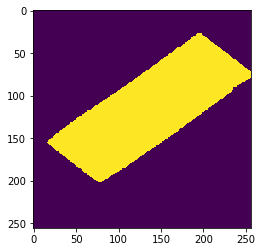

In [11]:
import matplotlib.pyplot as plt
plt.imshow(res[50].reshape(256,256))

In [5]:
n = 19
file_name = 'Swin_small_TTA_CHALE'
submission = pd.read_csv('./submission/sample_submission.csv', index_col=None)


# PredictionString 대입
for i, r in enumerate(res):
    submission = submission.append(
        {"image_id": raw_data.coco.loadImgs(raw_data.coco.getImgIds(i))[0]['file_name'], 
         "PredictionString": ' '.join(str(e) for e in r.tolist()[0])},
        ignore_index=True)

# submission.csv로 저장
submission.to_csv(f"./submission/{n}ensemble" + file_name + '.csv', index=False)